In [38]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import random
import numpy as np

%matplotlib inline

def create_model():
    n_classes = 2
    model_ft = models.resnet34(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, n_classes)
    return model_ft

class TransformFixMatch(object):
    def __init__(self, mean, std):
        self.weak = transforms.RandomHorizontalFlip()
            
        self.strong = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=128,
                                  padding=int(32*0.125),
                                  padding_mode='reflect'),
            transforms.RandomErasing(
                p=1, 
                ratio=(1, 1), 
                scale=(0.01, 0.01), 
                value="random")
            
            ])
        
    def __call__(self, x):
        return self.weak(x), self.strong(x)
    
class Labelled(object):
    def __init__(self, mean, std):
        self.transform_labeled = transforms.Compose([transforms.RandomHorizontalFlip()])
        
    def __call__(self, x):
        return self.transform_labeled(x)

In [39]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

generic_t = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std)])

unlabeled_t = TransformFixMatch(cifar10_mean, cifar10_std)

labeled_t = Labelled(cifar10_mean, cifar10_std)

In [40]:
labeled_dataset = datasets.ImageFolder('./hymenoptera_data/labeled/', transform=generic_t)
unlabeled_dataset = datasets.ImageFolder('./hymenoptera_data/unlabeled/', transform=generic_t)

labeled_loader = torch.utils.data.DataLoader(labeled_dataset, shuffle=True, batch_size=12)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, shuffle=True, batch_size=12)

In [52]:
X, y = next(iter(labeled_loader))
Xu, Xs = unlabeled_t(X)
Xr = labeled_t(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


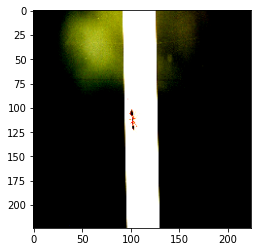

In [53]:
plt.imshow(Xr[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


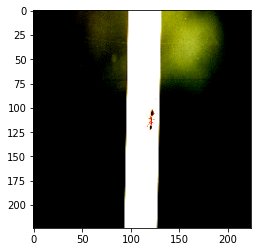

In [54]:
plt.imshow(Xu[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


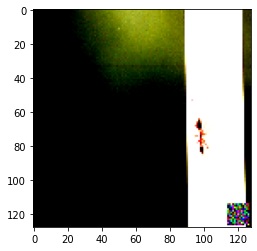

In [55]:
plt.imshow(Xs[0].permute(1,2,0))

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:
model = create_model()
model.to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [56]:
from tqdm import tqdm
model.train()
for epoch in tqdm(range(200)):
    X, y = next(iter(labeled_loader))
    X, y = X.to(device), y.to(device)
    optimizer_ft.zero_grad()
    X = labeled_t(X)
    logits = model(X)
    pred = F.softmax(logits, dim=1)
    loss = criterion(pred, y)
    loss.backward()
    optimizer_ft.step()

    acc = torch.sum(torch.argmax(pred, dim=1) == y) / len(y)
    if epoch % 10 == 0:
      print(f'supervised loss {loss.item():2f} accuracy {acc.item()}')


    # unlabelled  
    X, y = next(iter(unlabeled_loader))
    X, y = X.to(device), y.to(device)

    optimizer_ft.zero_grad()
    Xu, Xs = unlabeled_t(X)
    
    # generate fake labels
    logits = model(Xu)
    pred = F.softmax(logits, dim=1)
    select = torch.max(pred, dim=1).values > 0.5
    if torch.sum(select) > 0:
      fake_label = torch.argmax(pred[select], dim=1)
      Xs_logits = model(Xs[select])
      Xs_pred = F.softmax(Xs_logits, dim=1)
      loss = criterion(Xs_pred, fake_label)
      loss.backward()
      optimizer_ft.step()
      fake_acc = torch.sum(torch.argmax(Xs_pred, dim=1) == y[select]) / len(select)
      if epoch % 10 == 0:
        print('fake acc', fake_acc.item(), Xs_pred)

  0%|          | 0/200 [00:00<?, ?it/s]

supervised loss 0.314679 accuracy 1.0


  0%|          | 1/200 [00:00<02:11,  1.52it/s]

fake acc 0.8333333730697632 tensor([[3.8947e-02, 9.6105e-01],
        [4.0417e-04, 9.9960e-01],
        [5.0859e-04, 9.9949e-01],
        [3.8525e-03, 9.9615e-01],
        [1.7017e-02, 9.8298e-01],
        [9.7264e-01, 2.7360e-02],
        [3.1488e-01, 6.8512e-01],
        [4.0998e-03, 9.9590e-01],
        [9.7995e-01, 2.0052e-02],
        [4.6889e-04, 9.9953e-01],
        [9.8703e-01, 1.2968e-02],
        [9.9924e-01, 7.6429e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


  5%|▌         | 10/200 [00:04<01:26,  2.20it/s]

supervised loss 0.314772 accuracy 1.0


  6%|▌         | 11/200 [00:05<01:32,  2.05it/s]

fake acc 0.8333333730697632 tensor([[1.0907e-03, 9.9891e-01],
        [8.5043e-01, 1.4957e-01],
        [4.7416e-02, 9.5258e-01],
        [2.6001e-02, 9.7400e-01],
        [9.9894e-01, 1.0591e-03],
        [9.5691e-01, 4.3095e-02],
        [6.3203e-04, 9.9937e-01],
        [2.1483e-01, 7.8517e-01],
        [4.4033e-03, 9.9560e-01],
        [3.7082e-03, 9.9629e-01],
        [2.9175e-04, 9.9971e-01],
        [9.9569e-01, 4.3118e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 10%|█         | 20/200 [00:09<01:19,  2.26it/s]

supervised loss 0.317637 accuracy 1.0


 10%|█         | 21/200 [00:10<01:25,  2.09it/s]

fake acc 1.0 tensor([[1.2140e-01, 8.7860e-01],
        [6.8439e-03, 9.9316e-01],
        [9.9901e-01, 9.8842e-04],
        [5.2058e-04, 9.9948e-01],
        [9.9534e-01, 4.6574e-03],
        [4.1842e-03, 9.9582e-01],
        [5.5204e-05, 9.9994e-01],
        [5.9478e-02, 9.4052e-01],
        [2.9993e-03, 9.9700e-01],
        [9.9996e-01, 3.7269e-05],
        [3.6493e-03, 9.9635e-01],
        [3.8857e-02, 9.6114e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 15%|█▌        | 30/200 [00:14<01:15,  2.26it/s]

supervised loss 0.319098 accuracy 1.0


 16%|█▌        | 31/200 [00:14<01:20,  2.11it/s]

fake acc 0.9166666865348816 tensor([[6.8842e-09, 1.0000e+00],
        [9.9950e-01, 4.9659e-04],
        [1.8740e-01, 8.1260e-01],
        [8.4229e-06, 9.9999e-01],
        [1.9889e-04, 9.9980e-01],
        [9.8051e-01, 1.9489e-02],
        [9.9589e-01, 4.1103e-03],
        [9.9091e-01, 9.0897e-03],
        [9.0732e-01, 9.2676e-02],
        [7.8943e-02, 9.2106e-01],
        [9.8934e-01, 1.0658e-02],
        [1.9516e-03, 9.9805e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 20%|██        | 40/200 [00:18<01:13,  2.17it/s]

supervised loss 0.314145 accuracy 1.0


 20%|██        | 41/200 [00:19<01:21,  1.95it/s]

fake acc 0.8333333730697632 tensor([[8.8303e-01, 1.1697e-01],
        [3.8105e-03, 9.9619e-01],
        [1.1402e-01, 8.8598e-01],
        [9.9994e-01, 6.1903e-05],
        [9.7404e-01, 2.5965e-02],
        [3.4919e-04, 9.9965e-01],
        [2.9378e-02, 9.7062e-01],
        [9.9954e-01, 4.5847e-04],
        [8.7161e-01, 1.2839e-01],
        [1.3632e-04, 9.9986e-01],
        [2.0543e-05, 9.9998e-01],
        [7.7623e-05, 9.9992e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 25%|██▌       | 50/200 [00:23<01:07,  2.24it/s]

supervised loss 0.314272 accuracy 1.0


 26%|██▌       | 51/200 [00:23<01:11,  2.09it/s]

fake acc 0.8333333730697632 tensor([[4.5729e-06, 1.0000e+00],
        [1.2936e-03, 9.9871e-01],
        [7.1802e-01, 2.8198e-01],
        [9.9528e-01, 4.7211e-03],
        [6.5705e-02, 9.3429e-01],
        [2.7017e-01, 7.2983e-01],
        [5.6948e-02, 9.4305e-01],
        [4.3014e-05, 9.9996e-01],
        [8.5977e-01, 1.4023e-01],
        [1.2414e-03, 9.9876e-01],
        [9.9491e-01, 5.0909e-03],
        [9.9739e-01, 2.6050e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 30%|███       | 60/200 [00:28<01:04,  2.18it/s]

supervised loss 0.314530 accuracy 1.0


 30%|███       | 61/200 [00:28<01:07,  2.05it/s]

fake acc 0.9166666865348816 tensor([[9.9538e-01, 4.6209e-03],
        [3.7466e-02, 9.6253e-01],
        [9.9931e-01, 6.9020e-04],
        [1.2842e-02, 9.8716e-01],
        [9.9585e-01, 4.1545e-03],
        [9.9882e-01, 1.1836e-03],
        [1.8202e-05, 9.9998e-01],
        [2.3646e-03, 9.9764e-01],
        [3.9639e-05, 9.9996e-01],
        [9.9160e-01, 8.3987e-03],
        [5.3343e-04, 9.9947e-01],
        [5.1905e-05, 9.9995e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 35%|███▌      | 70/200 [00:32<00:58,  2.23it/s]

supervised loss 0.316779 accuracy 1.0


 36%|███▌      | 71/200 [00:33<01:05,  1.97it/s]

fake acc 0.8333333730697632 tensor([[9.9398e-01, 6.0181e-03],
        [8.6530e-03, 9.9135e-01],
        [1.6381e-04, 9.9984e-01],
        [5.9333e-01, 4.0667e-01],
        [3.4892e-01, 6.5108e-01],
        [9.8070e-01, 1.9298e-02],
        [9.2909e-05, 9.9991e-01],
        [6.9344e-03, 9.9307e-01],
        [1.7235e-01, 8.2765e-01],
        [9.9996e-01, 4.2221e-05],
        [3.7554e-04, 9.9962e-01],
        [2.2776e-03, 9.9772e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 40%|████      | 80/200 [00:37<00:53,  2.24it/s]

supervised loss 0.313691 accuracy 1.0


 40%|████      | 81/200 [00:38<00:57,  2.07it/s]

fake acc 0.8333333730697632 tensor([[6.2555e-01, 3.7445e-01],
        [9.9854e-01, 1.4639e-03],
        [4.1555e-03, 9.9584e-01],
        [1.9507e-09, 1.0000e+00],
        [7.1106e-01, 2.8894e-01],
        [9.9722e-01, 2.7834e-03],
        [1.0462e-01, 8.9538e-01],
        [8.0172e-01, 1.9828e-01],
        [6.4399e-03, 9.9356e-01],
        [7.8770e-05, 9.9992e-01],
        [9.7481e-01, 2.5193e-02],
        [7.4434e-01, 2.5566e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 45%|████▌     | 90/200 [00:42<00:49,  2.21it/s]

supervised loss 0.329378 accuracy 1.0


 46%|████▌     | 91/200 [00:42<00:53,  2.05it/s]

fake acc 0.9166666865348816 tensor([[9.9665e-01, 3.3510e-03],
        [9.8673e-01, 1.3270e-02],
        [1.5131e-03, 9.9849e-01],
        [9.7692e-01, 2.3080e-02],
        [7.4276e-01, 2.5724e-01],
        [5.9339e-01, 4.0661e-01],
        [1.2215e-01, 8.7785e-01],
        [1.0887e-05, 9.9999e-01],
        [2.4903e-03, 9.9751e-01],
        [3.8932e-03, 9.9611e-01],
        [1.8771e-03, 9.9812e-01],
        [2.4907e-01, 7.5093e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 50%|█████     | 100/200 [00:47<00:52,  1.91it/s]

supervised loss 0.336428 accuracy 1.0


 50%|█████     | 101/200 [00:47<00:52,  1.87it/s]

fake acc 0.9166666865348816 tensor([[2.0836e-03, 9.9792e-01],
        [9.9916e-01, 8.4157e-04],
        [9.8550e-01, 1.4496e-02],
        [1.2073e-03, 9.9879e-01],
        [9.9911e-01, 8.8771e-04],
        [5.3013e-03, 9.9470e-01],
        [9.9969e-01, 3.0980e-04],
        [1.9223e-04, 9.9981e-01],
        [1.5630e-04, 9.9984e-01],
        [2.2021e-02, 9.7798e-01],
        [5.2636e-05, 9.9995e-01],
        [3.6331e-01, 6.3669e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 55%|█████▌    | 110/200 [00:51<00:41,  2.19it/s]

supervised loss 0.315470 accuracy 1.0


 56%|█████▌    | 111/200 [00:52<00:43,  2.06it/s]

fake acc 1.0 tensor([[9.9990e-01, 1.0306e-04],
        [1.6544e-02, 9.8346e-01],
        [1.8251e-03, 9.9817e-01],
        [5.1934e-03, 9.9481e-01],
        [1.5875e-04, 9.9984e-01],
        [9.9562e-01, 4.3822e-03],
        [1.0572e-02, 9.8943e-01],
        [2.5088e-05, 9.9997e-01],
        [9.8835e-01, 1.1647e-02],
        [9.7569e-01, 2.4310e-02],
        [3.9803e-05, 9.9996e-01],
        [9.9082e-01, 9.1828e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 60%|██████    | 120/200 [00:56<00:35,  2.27it/s]

supervised loss 0.316774 accuracy 1.0


 60%|██████    | 121/200 [00:56<00:37,  2.09it/s]

fake acc 0.9166666865348816 tensor([[5.1443e-05, 9.9995e-01],
        [3.9167e-01, 6.0833e-01],
        [5.3929e-02, 9.4607e-01],
        [9.9925e-01, 7.5059e-04],
        [9.9889e-01, 1.1118e-03],
        [3.9634e-02, 9.6037e-01],
        [2.3515e-04, 9.9976e-01],
        [1.5544e-01, 8.4456e-01],
        [1.7600e-03, 9.9824e-01],
        [5.6723e-01, 4.3277e-01],
        [1.2010e-04, 9.9988e-01],
        [9.8411e-01, 1.5887e-02]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 65%|██████▌   | 130/200 [01:00<00:31,  2.24it/s]

supervised loss 0.314933 accuracy 1.0


 66%|██████▌   | 131/200 [01:01<00:36,  1.90it/s]

fake acc 0.9166666865348816 tensor([[1.6705e-02, 9.8329e-01],
        [6.8818e-03, 9.9312e-01],
        [9.9276e-01, 7.2442e-03],
        [5.2140e-04, 9.9948e-01],
        [3.7020e-02, 9.6298e-01],
        [9.9996e-01, 4.4793e-05],
        [1.4925e-01, 8.5075e-01],
        [9.9163e-01, 8.3730e-03],
        [9.9775e-01, 2.2508e-03],
        [1.2788e-03, 9.9872e-01],
        [8.7277e-07, 1.0000e+00],
        [7.9184e-04, 9.9921e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 70%|███████   | 140/200 [01:05<00:28,  2.09it/s]

supervised loss 0.320340 accuracy 1.0


 70%|███████   | 141/200 [01:06<00:29,  1.99it/s]

fake acc 0.9166666865348816 tensor([[9.9813e-01, 1.8746e-03],
        [1.0335e-02, 9.8966e-01],
        [1.9935e-02, 9.8007e-01],
        [8.5281e-01, 1.4719e-01],
        [7.2095e-04, 9.9928e-01],
        [9.9097e-01, 9.0256e-03],
        [8.2024e-02, 9.1798e-01],
        [4.0575e-02, 9.5943e-01],
        [1.4099e-05, 9.9999e-01],
        [9.8703e-01, 1.2974e-02],
        [2.4714e-02, 9.7529e-01],
        [4.7787e-03, 9.9522e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 75%|███████▌  | 150/200 [01:10<00:22,  2.20it/s]

supervised loss 0.313661 accuracy 1.0


 76%|███████▌  | 151/200 [01:10<00:23,  2.07it/s]

fake acc 0.9166666865348816 tensor([[3.3324e-07, 1.0000e+00],
        [9.2239e-01, 7.7610e-02],
        [9.9928e-01, 7.2344e-04],
        [9.1254e-01, 8.7462e-02],
        [9.6233e-01, 3.7668e-02],
        [2.2328e-03, 9.9777e-01],
        [8.0944e-06, 9.9999e-01],
        [9.9579e-01, 4.2093e-03],
        [9.2076e-01, 7.9240e-02],
        [3.1695e-04, 9.9968e-01],
        [8.0426e-03, 9.9196e-01],
        [6.9586e-01, 3.0414e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 80%|████████  | 160/200 [01:14<00:17,  2.23it/s]

supervised loss 0.315012 accuracy 1.0


 80%|████████  | 161/200 [01:15<00:18,  2.10it/s]

fake acc 0.9166666865348816 tensor([[1.1638e-03, 9.9884e-01],
        [9.3790e-01, 6.2097e-02],
        [1.4267e-03, 9.9857e-01],
        [5.4796e-04, 9.9945e-01],
        [3.9567e-03, 9.9604e-01],
        [9.6212e-01, 3.7876e-02],
        [9.9736e-01, 2.6412e-03],
        [6.0222e-05, 9.9994e-01],
        [1.1518e-02, 9.8848e-01],
        [9.9854e-01, 1.4645e-03],
        [9.8292e-01, 1.7083e-02],
        [4.7124e-03, 9.9529e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 85%|████████▌ | 170/200 [01:19<00:13,  2.17it/s]

supervised loss 0.314029 accuracy 1.0


 86%|████████▌ | 171/200 [01:20<00:14,  2.04it/s]

fake acc 1.0 tensor([[9.9546e-01, 4.5445e-03],
        [9.2315e-04, 9.9908e-01],
        [4.4639e-01, 5.5361e-01],
        [1.3701e-02, 9.8630e-01],
        [5.8774e-03, 9.9412e-01],
        [3.4668e-02, 9.6533e-01],
        [8.6284e-05, 9.9991e-01],
        [6.4046e-03, 9.9360e-01],
        [9.9821e-01, 1.7870e-03],
        [9.9910e-01, 8.9954e-04],
        [6.8931e-05, 9.9993e-01],
        [8.3491e-01, 1.6509e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 90%|█████████ | 180/200 [01:24<00:08,  2.23it/s]

supervised loss 0.317381 accuracy 1.0


 90%|█████████ | 181/200 [01:24<00:09,  2.08it/s]

fake acc 0.9166666865348816 tensor([[5.8931e-04, 9.9941e-01],
        [3.0215e-07, 1.0000e+00],
        [7.6649e-01, 2.3351e-01],
        [9.9477e-01, 5.2326e-03],
        [3.4275e-02, 9.6572e-01],
        [2.7695e-03, 9.9723e-01],
        [9.9925e-01, 7.5050e-04],
        [9.4672e-01, 5.3279e-02],
        [1.2226e-02, 9.8777e-01],
        [5.4858e-04, 9.9945e-01],
        [9.9978e-01, 2.2192e-04],
        [3.3900e-02, 9.6610e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


 95%|█████████▌| 190/200 [01:28<00:04,  2.24it/s]

supervised loss 0.314376 accuracy 1.0


 96%|█████████▌| 191/200 [01:29<00:04,  2.11it/s]

fake acc 0.8333333730697632 tensor([[8.9528e-05, 9.9991e-01],
        [6.3965e-05, 9.9994e-01],
        [9.9108e-01, 8.9234e-03],
        [9.8408e-01, 1.5916e-02],
        [6.8431e-03, 9.9316e-01],
        [9.9989e-01, 1.1442e-04],
        [2.3777e-06, 1.0000e+00],
        [9.9975e-01, 2.5205e-04],
        [1.8581e-01, 8.1419e-01],
        [8.7566e-01, 1.2434e-01],
        [4.1887e-02, 9.5811e-01],
        [1.0907e-04, 9.9989e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


In [57]:
model.eval()
test_dataset = datasets.ImageFolder('./hymenoptera_data/holdout/', transform=generic_t)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=8)
len(test_dataset)

92

In [58]:
total = []
for X, y in test_loader:
  X, y = X.to(device), y.to(device)
  logits = model(X)
  pred = torch.argmax(logits, dim=1)
  correct = torch.sum(pred == y)
  total.append(correct.item())
np.sum(total) / len(test_dataset)


0.9239130434782609

In [50]:
from tqdm import tqdm

# baseline
baseline = create_model()
baseline.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(baseline.parameters(), lr=1e-3, momentum=0.9)
baseline.train()

for epoch in tqdm(range(200)):
    X, y = next(iter(labeled_loader))
    X, y = X.to(device), y.to(device)
    optimizer_ft.zero_grad()
    X = labeled_t(X)
    logits = baseline(X)
    pred = F.softmax(logits, dim=1)
    loss = criterion(pred, y)
    loss.backward()
    optimizer_ft.step()

    acc = torch.sum(torch.argmax(pred, dim=1) == y) / len(y)
    if epoch % 10 == 0:
      print(f'supervised loss {loss.item():2f} accuracy {acc.item()}')

  1%|          | 2/200 [00:00<00:44,  4.41it/s]

supervised loss 0.734846 accuracy 0.5


  6%|▌         | 12/200 [00:02<00:36,  5.17it/s]

supervised loss 0.601223 accuracy 0.6666666865348816


 11%|█         | 22/200 [00:04<00:33,  5.25it/s]

supervised loss 0.413938 accuracy 1.0


 16%|█▌        | 32/200 [00:05<00:32,  5.13it/s]

supervised loss 0.378135 accuracy 1.0


 21%|██        | 42/200 [00:07<00:30,  5.23it/s]

supervised loss 0.457905 accuracy 1.0


 26%|██▌       | 52/200 [00:09<00:28,  5.24it/s]

supervised loss 0.336063 accuracy 1.0


 31%|███       | 62/200 [00:11<00:26,  5.25it/s]

supervised loss 0.325279 accuracy 1.0


 36%|███▌      | 72/200 [00:13<00:25,  5.07it/s]

supervised loss 0.325125 accuracy 1.0


 41%|████      | 82/200 [00:15<00:22,  5.20it/s]

supervised loss 0.322808 accuracy 1.0


 46%|████▌     | 92/200 [00:16<00:20,  5.15it/s]

supervised loss 0.413250 accuracy 0.9166666865348816


 51%|█████     | 102/200 [00:18<00:19,  5.15it/s]

supervised loss 0.333287 accuracy 1.0


 56%|█████▌    | 112/200 [00:20<00:16,  5.19it/s]

supervised loss 0.320208 accuracy 1.0


 61%|██████    | 122/200 [00:22<00:15,  5.15it/s]

supervised loss 0.318641 accuracy 1.0


 66%|██████▌   | 132/200 [00:24<00:13,  5.16it/s]

supervised loss 0.317150 accuracy 1.0


 71%|███████   | 142/200 [00:25<00:11,  4.95it/s]

supervised loss 0.446344 accuracy 1.0


 76%|███████▌  | 152/200 [00:27<00:09,  5.10it/s]

supervised loss 0.343910 accuracy 1.0


 81%|████████  | 162/200 [00:29<00:07,  5.01it/s]

supervised loss 0.318501 accuracy 1.0


 86%|████████▌ | 172/200 [00:31<00:05,  5.05it/s]

supervised loss 0.328538 accuracy 1.0


 91%|█████████ | 182/200 [00:33<00:03,  5.12it/s]

supervised loss 0.317773 accuracy 1.0


 96%|█████████▌| 192/200 [00:35<00:01,  5.03it/s]

supervised loss 0.345308 accuracy 1.0


100%|██████████| 200/200 [00:36<00:00,  5.45it/s]


In [51]:
baseline.eval()
total = []
for X, y in test_loader:
  X, y = X.to(device), y.to(device)
  logits = baseline(X)
  pred = torch.argmax(logits, dim=1)
  correct = torch.sum(pred == y)
  total.append(correct.item())
np.sum(total) / len(test_dataset)


0.8695652173913043